In [15]:
import math
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

nue = uproot.open("root_files/nue.root")[fold][tree]
variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trkshr_score_v", "backtracked_pdg", "shr_theta_v",
    "shr_pfp_id_v", "category", "shr_tkfit_dedx_Y", "trk_pfp_id", "shr_energy_tot",
    "trk_energy_tot", "shr_hits_tot", "ccnc", "shr_dedx_y_v", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", "nslice", "npion", "nproton", "nu_e",
    "n_showers_contained", "shr_px", "shr_py", "shr_pz", "shr_distance", "trk_distance",
    "tksh_distance", "hits_y", "mc_pdg", "mc_vx", "mc_vy", "mc_vz", "mc_endx", "mc_endy", "mc_endz",
    "proton_e", "elec_e", "isVtxInFiducial", "npi0", "vtx_x", "nu_vtx_x", "vtx_y", "nu_vtx_y", "vtx_z", "nu_vtx_z",
    "xsceoffset", "ysceoffset", "zsceoffset", "xtimeoffset", "shr_energy", "theta"
]

nue = nue.pandas.df(variables, flatten=False)

In [5]:
def is_fidvol(x, y, z):
    return (x + 10 < 256) & (x - 10 > 0) & (y + 15 < 116.5) & (
        y - 15 > -116.5) & (z - 10 > 0) & (z + 50 < 1046.5)


def is_fiducial(x, y, z):
    try:
        x_1 = x[:, 0] > 10
        x_2 = x[:, 1] > 10
        y_1 = y[:, 0] > 15
        y_2 = y[:, 1] > 15
        z_1 = z[:, 0] > 10
        z_2 = z[:, 1] > 50

        return x_1 & x_2 & y_1 & y_2 & z_1 & z_2
    except IndexError:
        return True


def true_selection(sample, extra_cut=""):

    mc_pdg = sample["mc_pdg"].ravel()
    mc_vx = sample["mc_vx"].ravel()
    mc_vy = sample["mc_vy"].ravel()
    mc_vz = sample["mc_vz"].ravel()
    mc_endx = sample["mc_endx"].ravel()
    mc_endy = sample["mc_endy"].ravel()
    mc_endz = sample["mc_endz"].ravel()

    mc_p_v = [
        is_fidvol(vx[np.where(pdg == 2212)], vy[np.where(pdg == 2212)],
                  vz[np.where(pdg == 2212)])
        for pdg, vx, vy, vz in zip(mc_pdg, mc_vx, mc_vy, mc_vz)
    ]

    mc_p_e = [
        is_fidvol(ex[np.where(pdg == 2212)], ey[np.where(pdg == 2212)],
                  ez[np.where(pdg == 2212)])
        for pdg, ex, ey, ez in zip(mc_pdg, mc_endx, mc_endy, mc_endz)
    ]

    mc_elec_v = [
        is_fidvol(vx[np.where(pdg == 11)], vy[np.where(pdg == 11)],
                  vz[np.where(pdg == 11)])
        for pdg, vx, vy, vz in zip(mc_pdg, mc_vx, mc_vy, mc_vz)
    ]

    mc_p_is_fidvol = [all(v) and all(e) for v, e in zip(mc_p_v, mc_p_e)]
    mc_elec_is_fidvol = [all(e) for e in mc_elec_v]

    sample["mc_p_is_fidvol"] = mc_p_is_fidvol
    sample["mc_e_is_fidvol"] = mc_elec_is_fidvol
    
    sample['vtx_x_corrected'] = sample['vtx_x'] - sample['xsceoffset'] + sample['xtimeoffset'] + 0.6
    sample['vtx_y_corrected'] = sample['vtx_y'] + sample['ysceoffset']
    sample['vtx_z_corrected'] = sample['vtx_z'] + sample['zsceoffset']
    
    sample["true_distance"] = sample.eval("sqrt((vtx_x_corrected-nu_vtx_x)**2+(vtx_y_corrected-nu_vtx_y)**2+(vtx_z_corrected-nu_vtx_z)**2)")

    true_selection = sample.query(
        "mc_e_is_fidvol == True & mc_p_is_fidvol == True & (proton_e - 0.938) > 0.04 & (elec_e - 0.00052) > 0.03 & isVtxInFiducial == True & npion == 0 & npi0 == 0"
    )
    
    if extra_cut:
        true_selection = true_selection.query(extra_cut)

    return true_selection



def efficiency(true_sample, variable, query,
               **hist_options):

    reco_selected = true_sample.query(query)
    den, bins = np.histogram(true_sample.eval(variable), **hist_options)
    num, bins = np.histogram(reco_selected.eval(variable), **hist_options)

    err = 1 / den * np.sqrt(num * (1 - num / den))

    return num, den, err, bins


def efficiency_plot(ax,
                    true_sample,
                    variable,
                    query,
                    label='',
                    **hist_options):
    num, den, err, bins = efficiency(true_sample,
                                     variable, query, **hist_options)
    eff = num / den
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    eff = ax.errorbar(
        bincenters,
        eff,
        yerr=err,
        xerr=0.5*(hist_options["range"][1]-hist_options["range"][0])/hist_options["bins"],
        fmt='none',
        label='%s: %.1f%%' % (label, sum(num) / sum(den) * 100))

    return eff, sum(num) / sum(den)

In [6]:
true_selected = true_selection(nue)
true_selected_dist = true_selection(nue, extra_cut="true_distance < 1")

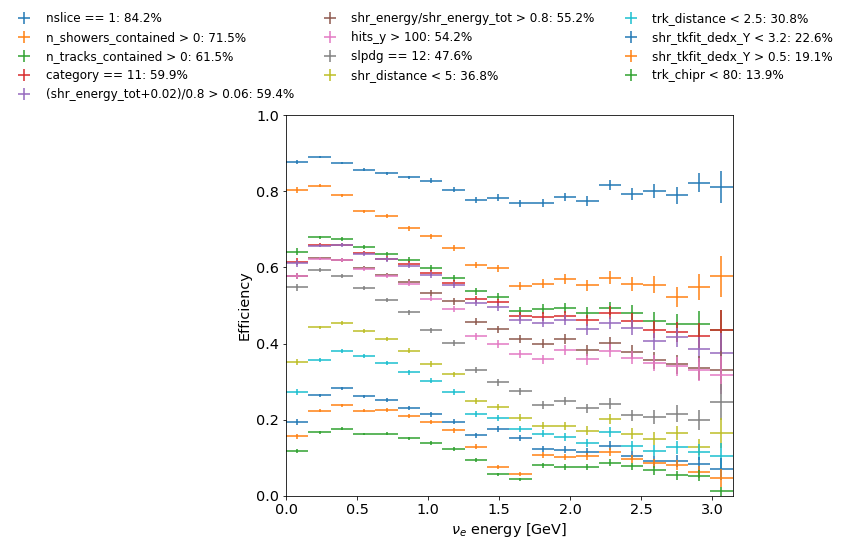

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

cuts = [
    "nslice == 1",
    "n_showers_contained > 0",
    "n_tracks_contained > 0",
    "category == 11",
    "(shr_energy_tot+0.02)/0.8 > 0.06",
    "shr_energy/shr_energy_tot > 0.8",
    "hits_y > 100",
    "slpdg == 12",
    "shr_distance < 5",
    "trk_distance < 2.5",
    "shr_tkfit_dedx_Y < 3.2",
    "shr_tkfit_dedx_Y > 0.5",
    "trk_chipr < 80",
]

query = ""

effs = []
effs_dist = []

for cut in cuts:
    if cut != cuts[0]:
        query = query + "&"
    query += cut

    plot, value = efficiency_plot(
        ax,
        true_selected,
        "theta",
        query,
        label=cut,
        range=(0, math.pi),
        bins=20)
    
#     plot_dist, value_dist = efficiency_plot(
#         ax,
#         true_selected_dist,
#         "nu_e",
#         query,
#         label=cut,
#         range=(0, 2),
#         bins=20)
    
    effs.append(value)
#     effs_dist.append(value_dist)
    leg = ax.legend(loc='bottom right', bbox_to_anchor=(1.25, 1.3), ncol=3, frameon=False)

ax.set_ylim(0, 1)
ax.set_xlim(0, math.pi)
ax.set_ylabel("Efficiency")
ax.set_xlabel(r"$\nu_e$ energy [GeV]")

fig.savefig("plots/eff.pdf", transparent=True)

Text(0, 0.5, 'Efficiency')

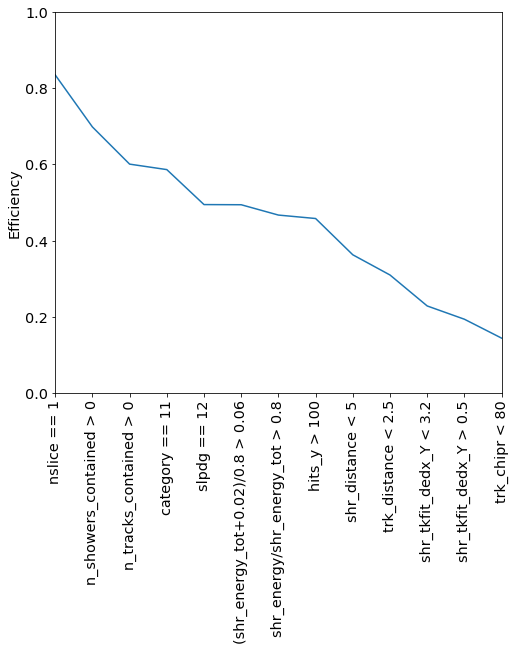

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
ax.plot(effs, label="Rectangular cuts")
# ax.plot(effs_dist, label="Rectangular cuts with reco. vertex within 2 cm")
x = range(len(effs))
ticks = plt.xticks(x,cuts,rotation='90')
ax.set_ylim(0,1)
ax.set_xlim(0,len(effs)-1)
ax.set_ylabel("Efficiency")
# leg = ax.legend()